### Modeling Steps
- Break timeline into two periods: Dev, Backtest
- Pick a strategy. In Dev period, for each stock, run the strategy with different parameters on all the days and then calculate the performance metrics
- For each stock, pick the best parameters.
- Run the strategy with the best parameters in Backtest period, and report its performance metrics

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import math
import re

import numpy as np
import pandas as pd
from tqdm import tqdm

from tttrade import backtests
from tttrade import datasources
from tttrade import strategy
from tttrade import timeseries
from tttrade import utility as tutil

db = tutil.db
sina_ds = datasources.SinaDataSource()



In [2]:
c_symbols = [r['symbol'] for r in db['dict_symbols'].find({'type1': 'stock'})]
symbols = []
for symbol in tqdm(c_symbols):
    try:
        market_cap = sina_ds.get_marketcap_for_one_stock(symbol)
    except:
        continue
    if market_cap > 1000000000 * 10:
        symbols.append(symbol)
print(len(symbols))
    

100%|██████████| 7033/7033 [10:48<00:00, 10.85it/s]

796


In [7]:
risk_free_rate = 0.0409
dev_period = ('2024-08-21', '2024-08-30')
backtest_period = ('2024-09-03', '2024-09-06')
# paras = [(i, i+j) for i in range(3, 10) for j in range(5, 15)]
macd_paras = [(i, i+j, i-3) for i in range(12, 18) for j in range(14, 16)]
# dfs_final = []
# for symbol in tqdm(symbols):
#     dfs = []
#     try:
#         for short_window, long_window in paras:
#             sty_sma = strategy.StySimpleMA(short_window=short_window, long_window=long_window)
#             df = backtests.trade_one_stock_in_period(symbol, dev_period[0], dev_period[1], sty_sma, risk_free_rate)
#             dfs.append(df)
#         df2 = pd.concat(dfs, axis=0)
#         market_cap = sina_ds.get_marketcap_for_one_stock(symbol)
#         liquidity = sina_ds.get_liquidity_for_one_stock(symbol, start_date=dev_period[0], end_date=dev_period[0])
#         df2['Market Cap'] = market_cap
#         df2['Liquidity'] = liquidity
#         cols = list(df2.columns)
#         cols = cols[:2] + ['Market Cap', 'Liquidity'] + cols[2:-2]
#         df2 = df2[cols]
#         dfs_final.append(df2)
#     except Exception as e:
#         print(str(e))
#         continue
# df_final = pd.concat(dfs_final, axis=0)

dfs = []
for short_window, long_window, signal_window in tqdm(macd_paras):
    # sty_sma = strategy.StySimpleMA(short_window=short_window, long_window=long_window)
    sty_macd = strategy.StyMACD(short_window=short_window, long_window=long_window, signal_window=signal_window)
    df = backtests.trade_stocks_in_period(symbols, dev_period[0], dev_period[1], sty_macd, risk_free_rate)
    dfs.append(df)
df_final = pd.concat(dfs, axis=0)

100%|██████████| 12/12 [07:50<00:00, 39.25s/it]


In [8]:
r2 = [r for r in db['dict_symbols'].find({'type1': 'stock', 'sector': 'Technology'}, {'_id': 0, 'symbol': 1, 'name': 1})]
df_name = pd.DataFrame(r2)
df_final = pd.concat([group.nlargest(1, 'Sharpe Ratio') for _, group in df_final.groupby('symbol')])
df_final = pd.merge(df_final, df_name, on='symbol', how='left')
cols = list(df_final.columns)
cols = cols[:1] + ['name'] + cols[:-1]
df_final = df_final[cols]
fn = 'train_macd_791_stocks.xlsx'
df_final.to_excel(fn, index=False)

In [9]:
df_train = pd.read_excel(fn)
# df_train.to_dict(orient='records')

In [10]:
# Backtest
dfs = []
for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
    try:
        symbol = row['symbol']
        sn = row['Strategy']
        short_window = int(re.search(r'short_window=(\d+)', sn).group(1))
        long_window = int(re.search(r'long_window=(\d+)', sn).group(1))
        signal_window = int(re.search(r'signal_window=(\d+)', sn).group(1))
        # sty_sma = strategy.StySimpleMA(short_window=short_window, long_window=long_window)
        sty_macd = strategy.StyMACD(short_window=short_window, long_window=long_window, signal_window=signal_window)
        df = backtests.trade_one_stock_in_period(symbol, backtest_period[0], backtest_period[1], sty_macd, risk_free_rate)
        
        dfs.append(df)
    except Exception as e:
        continue
df_backtest = pd.concat(dfs, axis=0)

100%|██████████| 796/796 [01:31<00:00,  8.67it/s]


In [12]:
df_train_test = pd.merge(df_train, df_backtest, on='symbol', how='left')
df_train_test['Is Good'] = df_train_test[['Sharpe Ratio_x', 'Sharpe Ratio_y']].apply(lambda x: 0 if math.fabs((x[1]-x[0])/x[0]) < 0.2 else 1, axis=1)
df_train_test = df_train_test.round(2)
df_train_test = df_train_test.sort_values(by='Sharpe Ratio_y', ascending=False)
df_train_test = df_train_test[(df_train_test['Is Good']==0) & (df_train_test['Sharpe Ratio_y']>0)]
df_train_test.to_excel('train_test_macd_791_stocks.xlsx', index=False)

In [19]:
# Backtest on one stock
t_symbol = 'WPP'
# t_sty_sma = strategy.StySimpleMA(short_window=8, long_window=17)
t_sty_macd = strategy.StyMACD(short_window=13, long_window=27, signal_window=10)
for t_ddate in ['2024-09-09', '2024-09-10']:
    stock_ts = timeseries.get_stock_price_minute(t_symbol, t_ddate)
    perf = backtests.trade_one_stock_in_day(t_symbol, t_ddate, t_sty_macd)
    print(f'Daily Return: {perf["daily_return"]:.2%}')
    print(f'# Trades: {perf["n_trades"]}')
    print(f'# Wins: {perf["n_wins"]}')
    print('-'*17)

Daily Return: 0.25%
# Trades: 5
# Wins: 1
-----------------
Daily Return: 0.16%
# Trades: 3
# Wins: 1
-----------------


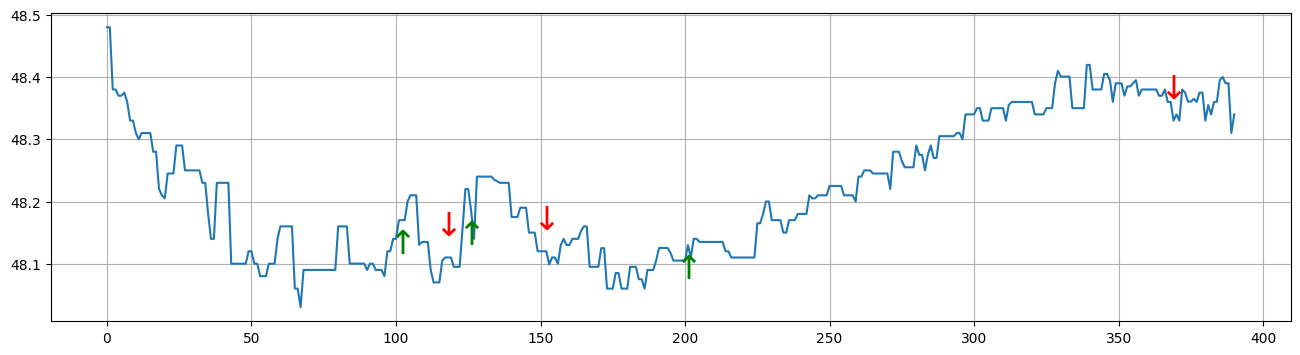

In [20]:
timeseries.plot_stock_ts_trade(stock_ts, perf['actu_signals'])